## External Resources in NWB with Patch-seq data

To prototype the inclusion of ontologized metadata in NWB, we have built this tutorial showing how to create files  including the new extensions and features:

- ndx-stimulation for stimulus waveform metadata
- ndx-genotype for strain, gene, and allele metadata
- ExternalResources for storing links to external databases and ontologies


In [1]:
from datetime import datetime
from dateutil.tz import tzlocal
import inspect
import numpy as np
import pandas as pd
import os

from pynwb import NWBHDF5IO, NWBFile
from pynwb.core import DynamicTableRegion, DynamicTable
from pynwb.device import Device

from pynwb import register_class, load_namespaces
from hdmf.utils import docval, call_docval_func, getargs, get_docval


# namespace for the SFT extension
ndx_stimulation_specpath = '/Users/pam.baker/Documents/ndx_stim/ndx-stimulation/spec/ndx-stimulation.namespace.yaml'

# namespace for the genotype extension
ndx_genotype_specpath = '/Users/pam.baker/Documents/ndx_stim/ndx-genotype/spec/ndx-genotype.namespace.yaml'

# Load the namespace                                                                                                 
load_namespaces(ndx_stimulation_specpath)
load_namespaces(ndx_genotype_specpath);

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Genotypes and Alleles Tables

For this iteration, the NWBFile we are building is a GenotypeNWBFile, as this supports the Genotype Table, External Resources, and ICEPhys Tables. The Stimulus Function Tables are added as a separate extension for now. Can I add both extensions concurrently and define e.g. the SFTNWBFile as a subtype of GenotypeNWBFile?

- Genotypes for locus and allele information
- Alleles to store allele metadata

In [3]:
from datetime import timezone
from ndx_genotype import GenotypeNWBFile, GenotypeSubject, GenotypesTable, AllelesTable

nwbfile = GenotypeNWBFile(
            session_start_time=datetime.now(timezone.utc),
            session_description='my first synthetic recording',
            identifier='EXAMPLE_ID',
            experimenter='Dr. Bilbo Baggins',
            lab='Bag End Laboratory',
            institution='University of Middle Earth at the Shire',
            experiment_description='I went on an adventure with thirteen dwarves to reclaim vast treasures.',
            session_id='LONELYMTN'
            )

# Note Subject.species should be ontologized as well
nwbfile.subject = GenotypeSubject(
            subject_id='3',
            genotype='Vip-IRES-Cre/wt',
            )

# Show adding the other attributes from the GenotypesTable in the External Resources
gt = GenotypesTable(
            process='PCR',
            process_url='https://dx.doi.org/10.17504/protocols.io.yjifuke',
            assembly='GRCm38.p6',
            annotation='NCBI Mus musculus Annotation Release 108',
            )

nwbfile.subject.genotypes_table = gt 

# Adding alleles
gt.add_allele(symbol='Vip-IRES-Cre')
gt.add_allele(symbol='wt')

gt.add_genotype(locus='Vip',
                allele1='Vip-IRES-Cre',
                allele2='wt',
                locus_resource_name='locus_resource_name',
                locus_resource_uri='locus_resource_uri',
                locus_entity_id='locus_entity_id',
                locus_entity_uri='locus_entity_uri')

/opt/anaconda3/envs/pynwb_recurse/lib/python3.9/site-packages/hdmf/container.py:181: UserWarning: ExternalResources is experimental -- it may be removed in the future and is not guaranteed to maintain backward compatibility
  warn(_exp_warn_msg(cls))


In [ ]:
# Display tables
#
gt.to_dataframe()
#gt.alleles_table.to_dataframe()

## External Resources Table

Since the GenotypesTable automatically generates an External Resources Table, we fetch the table already built into the GenotypesNWBFile for adding the SFT keys.

- Resources: eg ontology we are referencing
- Entities: as defined by an entry in ontology/controlled terms
- Keys: reference from object into the ER tables that maps onto entities 
- Objects: thing we are ontologizing (eg SFT)

In [ ]:
er = nwbfile.external_resources

## Stimulus Function Table

The stimulus function table is designed to hold the names of stimulus waveforms and their relevant parameters - float parameters for numeric values and function parameters that reference other waveform functions (for parameter values that vary as a function of time).

I have added the class constructor code here, and am adding entries using DynamicTable functionality.

In [ ]:
@register_class('StimulusFunctionTable', 'ndx-stimulation')
class StimulusFunctionTable(DynamicTable):   
    
    __columns__ = ( 
                    {'name':'function_name', 
                     'description': 'The names of the 1D stimulus waveforms.',
                     'required': True,
                     'index': False},
                    {'name':'float_parameters', 
                     'description': 'The names of the float parameters for the 1D stimulus waveforms.',
                     'required': True,
                     'index': True},
                    {'name':'function_parameters',
                     'description': 'The function parameters for the 1D stimulus waveforms.',
                     'required': True,
                     'index': True}
    )
    
    
    @docval(*get_docval(DynamicTable.__init__, 'id', 'columns', 'colnames'))
    def __init__(self, **kwargs):
        kwargs['name'] = ('StimulusFunctionTable')
        kwargs['description'] = ('Table for storing ontologized 1D stimulus waveform metadata')
        call_docval_func(super().__init__, kwargs)
        

We create an example stimulus function table to hold a couple of square waves with associated parameters. We use the add_row function inherited from Dynamic Tables to add new entries. 

In [ ]:
#
# Loop through and create entries for the IV stimulus protocol
#
# Create SFT
sft = StimulusFunctionTable()

# amplitudes of pulses that form sweep sequence - from file comments
amps = [i for i in range(60,-150,-20)]


# Loop through and add entries to SFT for each stimulus
# We can name the function what we want, but this will be the Key name to enter in ER
# Each Key name can only be used once in each field (eg IV will always be square pulses)
#
for j in amps:
    
    # Parameters for square wave
    float_params = [('amplitude', j*1e-12, 'A'),
                    ('duration', 3.0, 's'),
                    ('starting_time', 0.25, 's')]
    
    # Create the stimulus waveform
    stimwave = {'function_name':'IV', 
                'float_parameters': float_params, 
                'function_parameters':[]}
    
    # Add using add_row from DynamicTable (for now)
    sft.add_row(data = stimwave, id=666)
    
    
pd.set_option("display.max_colwidth", 100)
display(sft.to_dataframe())

The *StimulusFunctionTable* is the container object we will link to in the External Resources. We are linking the subfields of the SFT to the External Resources, so we use the `field` attribute to indicate which column or element of a compound data entry gets linked. Since this is not currently validated, we must be consistent when defining the field and using it to retrieve a key.

In [ ]:
sft_object_id = sft.object_id
print(sft_object_id)

In [ ]:
# add_ref creates an entry across all tables (entities, keys, objects, resources)

er.add_ref(container = sft_object_id, 
           field='function_name', 
           key='IV',
           resource_name='Estim Ontology',
           resource_uri='Estim_Ontology_uri',
           entity_id='square_pulse',
           entity_uri='Estim_square_pulse_uri'
          )

er.add_ref(container = sft_object_id, 
           field='float_parameter/name', 
           key='duration',
           resource_name='Estim Ontology',
           resource_uri='Estim_Ontology_uri',
           entity_id='duration',
           entity_uri='Estim_duration_uri'
          )

er.add_ref(container = sft_object_id, 
           field='float_parameter/name', 
           key='amplitude',
           resource_name='Estim Ontology',
           resource_uri='Estim_Ontology_uri',
           entity_id='amplitude',
           entity_uri='Estim_amplitude_uri'
          )

er.add_ref(container = sft_object_id, 
           field='float_parameter/name', 
           key='starting_time',
           resource_name='Estim Ontology',
           resource_uri='Estim_Ontology_uri',
           entity_id='shift',
           entity_uri='Estim_shift_uri'
          )

In [ ]:
nwbfile.external_resources.to_dataframe()

In [ ]:
er.keys.to_dataframe()

In [ ]:
er.entities.to_dataframe()

In [ ]:
key_object = er.get_key(key_name='amplitude', container=sft_object_id, field='float_parameter/name')
print(key_object)

## ICEPhys Tables

In [4]:
from pynwb.icephys import CurrentClampStimulusSeries, CurrentClampSeries
from pynwb import NWBHDF5IO
from pynwb.core import DynamicTable, VectorData

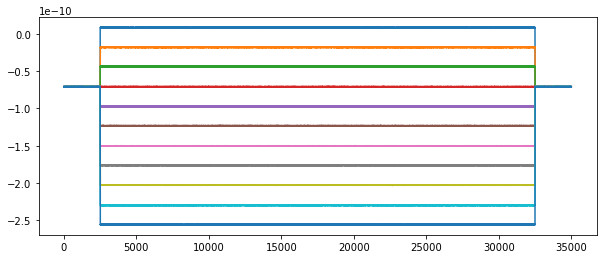

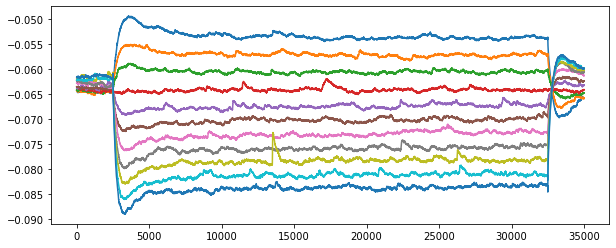

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

# Sweeps from AIBS file 
#
traces = np.load('001_140709EXP_A1_ndx_v3.npz')

# These were taken for the first repetition of the IV stimulus protocol
#
stims = traces['stims']
resps = traces['resps']
starts = traces['starts']
sweep_nums = traces['sweep_nums']
rates = traces['rates']
stim_names = traces['stim_names']

ds = stims
fig, ax = plt.subplots(1,1, figsize=(10,4));
ax.plot(ds);

ds = resps
fig, ax = plt.subplots(1,1, figsize=(10,4));
ax.plot(ds);

In [6]:
# Add device
device = nwbfile.create_device(name='Multiclamp 700B Axon Instruments')

# Add the intracellular electrode
electrode = nwbfile.create_icephys_electrode(name="Electrode_01",
                                        description="Electrode_Type:Chlorinated Ag+ wire,0.5 mm diameter#Electrode_Manufacturer:A-M Systems, Inc.",
                                        location="Anatomical_Location:Brain#Brain_Hemisphere:Right#Brain_Area:SSC",
                                        device=device)


In [7]:
# For storing row indices
rowindex = []

# Loop through and create timeseries and add to file
for i in range(11):
    #
    # Create an ic-ephys stimulus
    stimulus = CurrentClampStimulusSeries(
                name="ccss_"+str(sweep_nums[i]),
                data=stims[:,i],
                starting_time=starts[i],
                rate=rates[i],
                electrode=electrode,
                gain=1e-12,
                sweep_number=sweep_nums[i])
    #
    # Create an ic-response
    response = CurrentClampSeries(
                name="ccs_"+str(sweep_nums[i]),
                data=resps[:,i],
                starting_time=starts[i],
                rate=rates[i],
                electrode=electrode,
                gain=1e-12,
                sweep_number=sweep_nums[i])
    #
    # add to file
    rowindex = rowindex + [nwbfile.add_intracellular_recording(electrode=electrode,
                                                              stimulus=stimulus,
                                                              response=response,
                                                              id=sweep_nums[i])]
    

In [8]:
#
# Add column for stimulus label
# We can add this under the 'stimuli' category, 
# or to each row entry as a whole since the stim is relevant for responses as well
#
nwbfile.intracellular_recordings.add_column(
    name='stimulus_type', 
    data=['IV']*len(starts), 
    description='function_name in Stimulus Function Table',
    category='stimuli')

#nwbfile.intracellular_recordings.to_dataframe()

### Defining a protocol with Sequential Recordings

The hierachical tables are set up to define a logical grouping of recordings and sweeps, starting with temporal relationships between sweeps, up to organization by identical stimulus set/protocol, up to experimental conditions that altered for large chunks of a session. 

1. Group sweeps that were recorded simultaneously into the **simultaneous_recordings**
2. Add a series of simultaneous sweeps that form a protocol to **sequential_recordings**

In [ ]:
print(len(starts))

In [9]:
#icephys_simultaneous_recordings = nwbfile.get_icephys_simultaneous_recordings()

simrowindex = []

for i in range(len(starts)):
    simrowindex.extend([ nwbfile.add_icephys_simultaneous_recording(recordings=[rowindex[i]], id=(101+i)) ])

nwbfile.icephys_simultaneous_recordings.to_dataframe()

,recordings
id,
101,Empty DataFrame Columns: [] Index: [32]
102,Empty DataFrame Columns: [] Index: [33]
103,Empty DataFrame Columns: [] Index: [34]
104,Empty DataFrame Columns: [] Index: [35]
105,Empty DataFrame Columns: [] Index: [36]
106,Empty DataFrame Columns: [] Index: [37]
107,Empty DataFrame Columns: [] Index: [38]
108,Empty DataFrame Columns: [] Index: [39]
109,Empty DataFrame Columns: [] Index: [40]


In [11]:
#print(nwbfile.icephys_simultaneous_recordings)
## nwbfile.icephys_simultaneous_recordings['recordings'].target[:] -> empty dataframe MAKE COLUMN??

""
id
32
33
34
35
36
37
38
39
40


In [12]:
print(simrowindex)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [28]:
# Adding a set of sequential recordings

seqrowindex = nwbfile.add_icephys_sequential_recording(simultaneous_recordings=simrowindex, 
                                                       stimulus_type='IV', 
                                                       id=201)

ValueError: id 201 already in the table

In [27]:
nwbfile.icephys_sequential_recordings

sequential_recordings pynwb.icephys.SequentialRecordingsTable at 0x4950681344
Fields:
  colnames: ['simultaneous_recordings' 'stimulus_type']
  columns: (
    simultaneous_recordings_index <class 'hdmf.common.table.VectorIndex'>,
    simultaneous_recordings <class 'hdmf.common.table.DynamicTableRegion'>,
    stimulus_type <class 'hdmf.common.table.VectorData'>
  )
  description: A table for grouping different intracellular recording simultaneous_recordings from the SimultaneousRecordingsTable table together. This is typically used to group together simultaneous_recordings where the a sequence of stimuli of the same type with varying parameters have been presented in a sequence.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

### Write

In [ ]:
# Write the SFT out to file

from pynwb import NWBHDF5IO

io = NWBHDF5IO('sft_ert_geno.nwb', mode='w')
io.write(nwbfile)
io.close()

In [ ]:
# Reading in the file I just wrote

io = NWBHDF5IO('sft_ert_testy.nwb', mode='r', load_namespaces=True)
sft_nwbfile = io.read()

In [ ]:
# print(sft_nwbfile.acquisition)

sft_in = sft_nwbfile.get_acquisition()

In [ ]:
sft_in.to_dataframe()

In [ ]:
sft_in['function_parameters'].target[0]